In [4]:
from astropy.time import Time
import astropy.units as u
import astropy.coordinates as coord
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from twobody import KeplerOrbit, Barycenter
from thejoker import RVData

/home/sdouglas/.conda/envs/thejoker/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Make some fake data:

In [5]:
t0 = Time(58425.134, format='mjd')
K = 13.013 * u.km/u.s
orbit = KeplerOrbit(P=110*u.day, e=0.4, M0=0.52*u.radian, omega=1.6*u.radian, 
                    Omega=0*u.deg, i=90*u.deg, t0=t0)

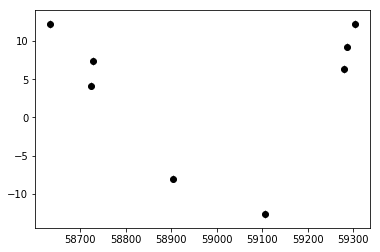

In [6]:
rnd = np.random.RandomState(seed=1234)
t = t0 + rnd.uniform(0, 3, size=8) * u.year
t = t.sort()

rv = K * orbit.unscaled_radial_velocity(t)
rv_err = np.ones(len(rv)) * 0.5 * u.km/u.s
rv = rnd.normal(rv, rv_err.to(rv.unit)) * rv.unit

data = RVData(t=t, rv=rv, stddev=rv_err)
_ = data.plot()

Text(0,0.5,'unscaled radial velocity')

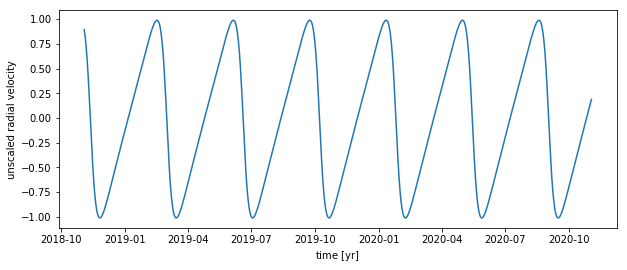

In [7]:
# If we don't specify K or a, then the absolute RV variation is unknown

t = t0 + np.linspace(0,2,1024) * u.year

unscaled_rv = orbit.unscaled_radial_velocity(t)

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(t.datetime, unscaled_rv, marker='')
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('unscaled radial velocity') 


Text(0,0.5,'radial velocity [$\\mathrm{km\\,s^{-1}}$]')

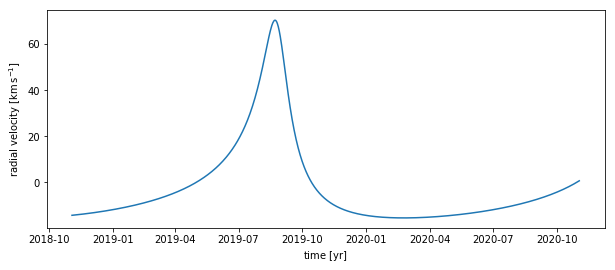

In [8]:
# We have to specify the semi-major axis to produce a real velocity amplitude
# But these are still computed relative to the barycenter/reference point of the orbit

orb = KeplerOrbit(P=1.5*u.year, e=0.67, a=1.77*u.au,
                  omega=17.14*u.deg, i=65*u.deg, Omega=0*u.deg,
                  M0=35.824*u.deg, t0=Time('J2015.0'))
rv = orb.radial_velocity(t)

fig,ax = plt.subplots(1, 1,figsize=(10,4)) 
ax.plot(t.datetime, rv.to(u.km/u.s).value, marker='') 
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('radial velocity [{0:latex_inline}]'.format(u.km/u.s)) 

Text(0,0.5,'radial velocity [$\\mathrm{km\\,s^{-1}}$]')

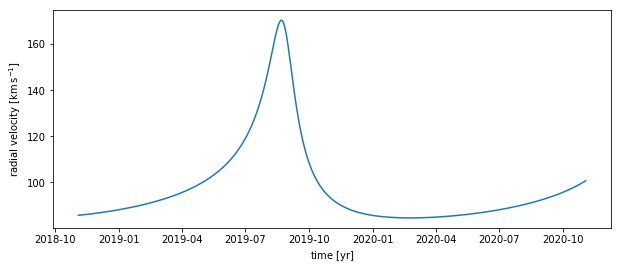

In [9]:
# Need to also add the barycentric or systematic velocity of the system 
# to get real line-of-sight velocities

v0 = 100 * u.km/u.s
fig,ax = plt.subplots(1, 1,figsize=(10,4)) 
ax.plot(t.datetime, (rv + v0).to(u.km/u.s).value, marker='') 
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('radial velocity [{0:latex_inline}]'.format(u.km/u.s)) 

In [10]:
# For sources with appreciable tangential motion over the timescale of observations, 
# There are additional effects due to spherical projection

# Plot the orbit from various perspectives

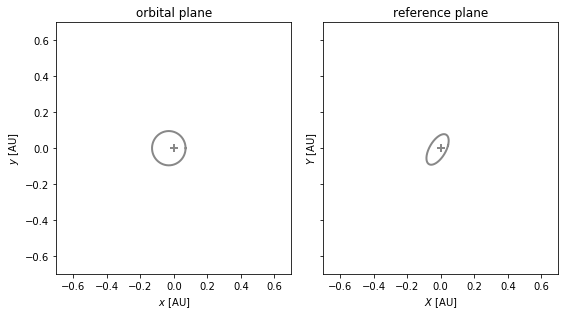

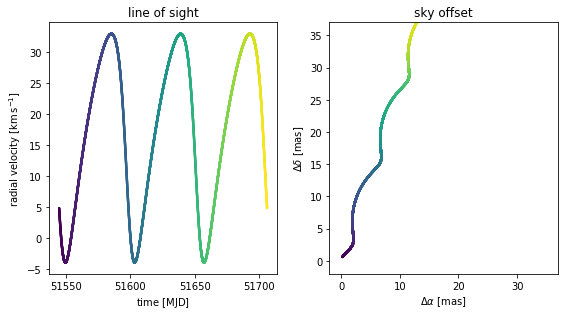

In [17]:

origin = coord.ICRS(ra=14.745*u.deg, dec=71.512*u.deg,
                    distance=71.634*u.pc,
                    pm_ra_cosdec=32.123*u.mas/u.yr,
                    pm_dec=86.63*u.mas/u.yr,
                    radial_velocity=17.4123*u.km/u.s)
b = Barycenter(origin=origin, t0=Time('J2000'))

orb = KeplerOrbit(P=54*u.day, a=0.1*u.au, e=0.3,
                  omega=2.124*u.rad, M0=0*u.rad, t0=Time('J2000'),
                  Omega=121.53*u.deg, i=61*u.deg,
                  barycenter=b)

t1 = Time('J2000') + np.linspace(0, orb.P.to(u.day).value, 10000)*u.day
xyz = orb.orbital_plane(t1)
XYZ = orb.reference_plane(t1).cartesian

orbit_style = dict(marker='', linestyle='-', linewidth=2, color='#888888')
body_style = dict(marker='o', linestyle='none', color='tab:red',
                  markersize=12, zorder=100)
barycen_style = dict(marker='+', color='#888888', mew=2, ms=8)

fig, axes = plt.subplots(1, 2, figsize=(8,4.5),
                         sharex=True, sharey=True)

axes[0].plot(xyz.x, xyz.y, **orbit_style)
axes[0].plot(0, 0, **barycen_style)

axes[1].plot(XYZ.x, XYZ.y, **orbit_style)
axes[1].plot(0, 0, **barycen_style)

lim = 0.7
for j in [0, 1]:
    axes[j].set_xlim(-lim, lim)
    axes[j].set_ylim(-lim, lim)


axes[0].set_xlabel('$x$ [{0:latex_inline}]'.format(xyz.x.unit))
axes[0].set_ylabel('$y$ [{0:latex_inline}]'.format(xyz.x.unit))

axes[1].set_xlabel('$X$ [{0:latex_inline}]'.format(xyz.x.unit))
axes[1].set_ylabel('$Y$ [{0:latex_inline}]'.format(xyz.x.unit))

axes[0].set_title('orbital plane')
axes[1].set_title('reference plane')

fig.tight_layout()

# --------------------
# plot 2

t2 = Time('J2000') + np.linspace(0, 3*orb.P.value, 10000)*orb.P.unit
icrs = orb.icrs(t2)
# TODO: this is only necessary because the released version of Astropy
# doesn't support velocity transforms in SkyOffsetFrame
_icrs = coord.ICRS(icrs.spherical.without_differentials())
_origin = coord.ICRS(origin.spherical.without_differentials())
offset = _icrs.transform_to(coord.SkyOffsetFrame(origin=_origin))
# offset = icrs.transform_to(coord.SkyOffsetFrame(origin=origin))

style = dict(marker='o', s=2, cmap='viridis')

fig, axes = plt.subplots(1, 2, figsize=(8, 4.5))

axes[0].scatter(t2.mjd, icrs.radial_velocity,
                c=t2.mjd, **style)
axes[0].set_xlabel(r'time [${\rm MJD}$]')
axes[0].set_ylabel(r'radial velocity [{0:latex_inline}]'
                   .format(icrs.radial_velocity.unit))
axes[0].set_title('line of sight')

axes[1].scatter(offset.lon.wrap_at(180*u.deg).milliarcsecond,
                offset.lat.milliarcsecond,
                c=t2.mjd, **style)
axes[1].set_xlabel(r'$\Delta\alpha$ [{0:latex_inline}]'.format(u.mas))
axes[1].set_ylabel(r'$\Delta\delta$ [{0:latex_inline}]'.format(u.mas))
axes[1].set_title('sky offset')
axes[1].set_xlim(-2, 37)
axes[1].set_ylim(-2, 37)

fig.tight_layout()

# Play with KeplerOrbit

Something's wrong with this - the period is too short for the system. Don't worry about this section

In [17]:
KeplerOrbit?

In [30]:
from twobody import TwoBodyKeplerElements, P_m_to_a,a_m_to_P
# TwoBodyKeplerElements?

In [26]:
binary_elem = TwoBodyKeplerElements(a=2*u.au, m1=1*u.solMass, m2=0.1*u.solMass, e=0,
                              omega=2.124*u.rad, M0=0*u.rad, t0=Time('J2000'),
                              Omega=121.53*u.deg, i=61*u.deg)

In [27]:
binary_orbit = KeplerOrbit(binary_elem)

Text(0,0.5,'radial velocity [$\\mathrm{km\\,s^{-1}}$]')

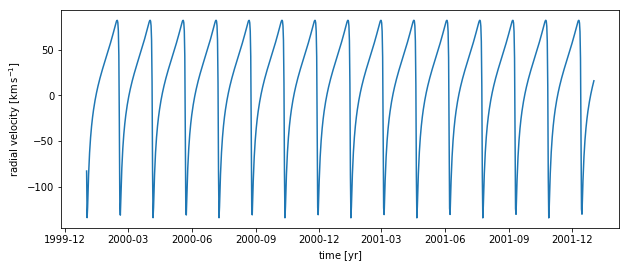

In [28]:
t = Time('J2000') + np.linspace(0,2,1024) * u.year
rv = orb.radial_velocity(t)

fig,ax = plt.subplots(1, 1,figsize=(10,4)) 
ax.plot(t.datetime, rv.to(u.km/u.s).value, marker='') 
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('radial velocity [{0:latex_inline}]'.format(u.km/u.s)) 

In [34]:
a = a_m_to_P(2*u.au, 1.1*u.solMass)

a.to(u.year)

<Quantity 2.69685038 yr>

In [ ]:
# OK something is very wrong with the KeplerOrbit thing then! Does not handle 2 massive bodies